In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from textblob import TextBlob


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import streamlit as st
import torch
import os
import re
import nltk
import string
import torch
import warnings


# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package punkt to /home/dell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
dataset_path = '../shopping_queries_dataset/'
locale ="us"
random_state = 42
n_dev_queries = 200

In [3]:
""" 0. Init variables """
col_query = "query"
col_query_id = "query_id"
col_product_id = "product_id" 
col_product_title = "product_title"
col_product_locale = "product_locale"
col_esci_label = "esci_label" 
col_small_version = "small_version"
col_split = "split"
col_gain = 'gain'
col_features = [col_product_id]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_print = "".join(['-']*40)
print(to_print)
print(f"---------> {device} is activated <----------")
print(to_print)
esci_label2gain = {
    'E' : 1.0,
    'S' : 0.1,
    'C' : 0.01,
    'I' : 0.0,
}

----------------------------------------
---------> cuda is activated <----------
----------------------------------------


In [4]:
""" 1. Load data """    
df_examples = pd.read_parquet(os.path.join(dataset_path, 'shopping_queries_dataset_examples.parquet'))
df_products = pd.read_parquet(os.path.join(dataset_path, 'shopping_queries_dataset_products.parquet'))
df_examples_products = pd.merge(
    df_examples,
    df_products,
    how='left',
    left_on=[col_product_locale, col_product_id],
    right_on=[col_product_locale, col_product_id]
)
df_examples_products = df_examples_products[df_examples_products[col_small_version] == 1]
df_examples_products = df_examples_products[df_examples_products[col_product_locale] == locale]
df_examples_products[col_gain] = df_examples_products[col_esci_label].apply(lambda esci_label: esci_label2gain[esci_label])

df_train = df_examples_products[df_examples_products[col_split] == "train"]
df_test = df_examples_products[df_examples_products[col_split] == "test"]

# This part of the code is for indexing and it is assumed the only input feature is product_title.
# Otherwise it shoudl be updated asccordingly
id_features_product_test = df_test[[col_product_id, col_product_title]].drop_duplicates(subset=col_product_title)

features_product_test = id_features_product_test[col_product_title].to_list()
id_product_test = id_features_product_test[col_product_id].to_list()

In [5]:
for name, df_ in {'df_train': df_train, 'df_test': df_test}.items():
    print(f"\nSample Size for {name}: {len(df_)}")
    print(f"\nNull Count for {name}:\n{df_.isnull().sum()}")
    


Sample Size for df_train: 419653

Null Count for df_train:
example_id                   0
query                        0
query_id                     0
product_id                   0
product_locale               0
esci_label                   0
small_version                0
large_version                0
split                        0
product_title                0
product_description     209360
product_bullet_point     48605
product_brand            20446
product_color           129176
gain                         0
dtype: int64

Sample Size for df_test: 181701

Null Count for df_test:
example_id                  0
query                       0
query_id                    0
product_id                  0
product_locale              0
esci_label                  0
small_version               0
large_version               0
split                       0
product_title               0
product_description     90884
product_bullet_point    21523
product_brand            9204
product_color 

Note: There is no null for 'query' neither for 'product_title'. Keeping all the rows.

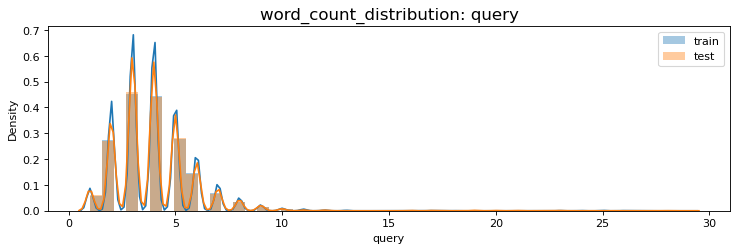

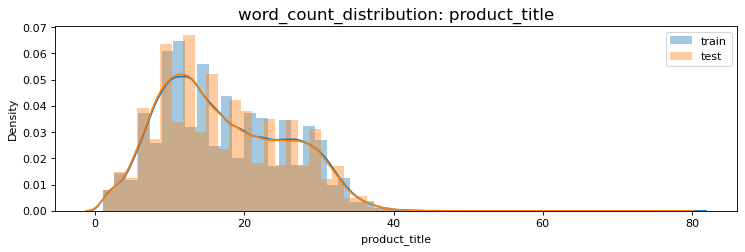

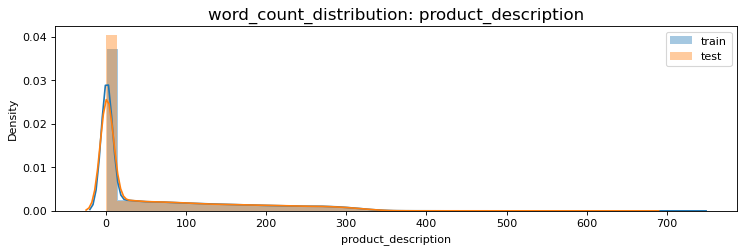

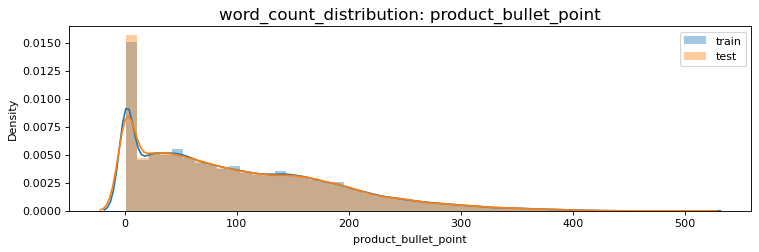

In [6]:
text_features = ['query', 'product_title', 'product_description', 'product_bullet_point']
colors = ['#9966ff', '#3399ff', '#00ff00', '#ff6600']


for feature, color in zip(text_features, colors): 
    plt.figure(figsize=(11, 3), dpi=80)
    sns.distplot(x=df_train[feature].apply(lambda x: len(str(x).split())), 
                 bins=50, label='train')
    sns.distplot(x=df_test[feature].apply(lambda x: len(str(x).split())), 
                 bins=50, label='test')    
    plt.title(f"word_count_distribution: {feature}", size=15)
    plt.xlabel(feature)
    plt.legend()
    plt.show()

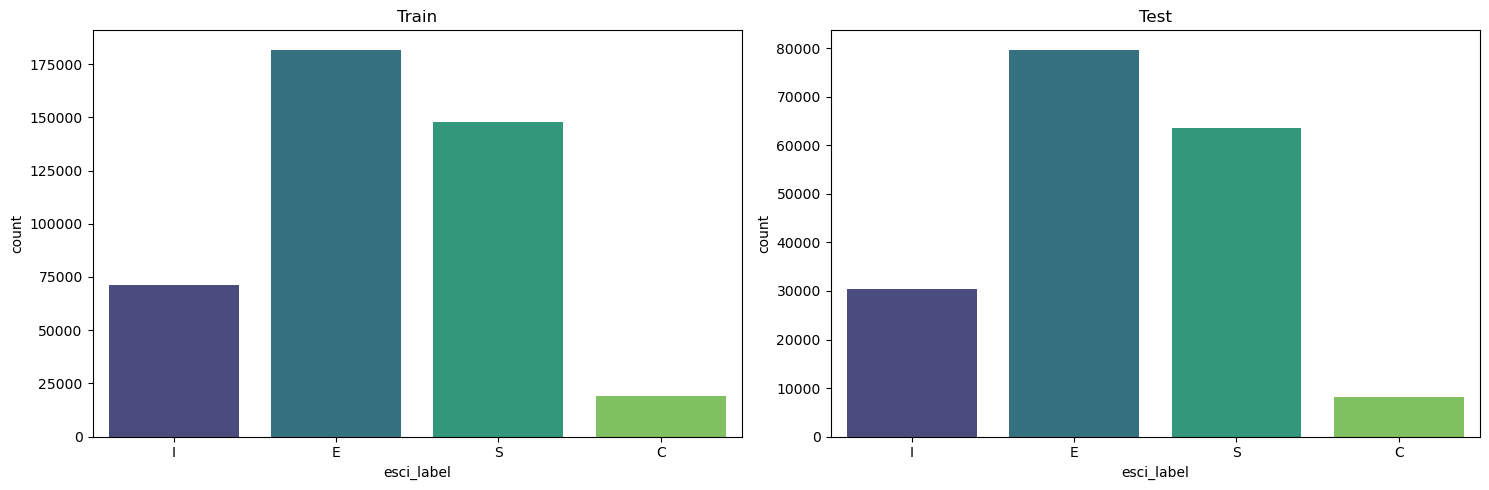

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x='esci_label', palette='viridis', data=df_train, ax=axes[0])
axes[0].set_title("Train")
sns.countplot(x='esci_label', palette='viridis', data=df_test, ax=axes[1])
axes[1].set_title("Test")
plt.tight_layout()
plt.show()

In [8]:
# Split train to train and dev
list_query_id = df_train[col_query_id].unique()
dev_size = n_dev_queries / len(list_query_id)
list_query_id_train, list_query_id_dev = train_test_split(list_query_id, test_size=dev_size, random_state=random_state)

df_train = df_examples_products[df_examples_products[col_query_id].isin(list_query_id_train)]
df_dev = df_examples_products[df_examples_products[col_query_id].isin(list_query_id_dev)]

## Explore Samples

In [9]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80)
idx = 0
print(
    f"> Query:\n{wrapper.fill(df_train.iloc[idx]['query'])}\n\n", 
    f"> Product Title:\n{wrapper.fill(df_train.iloc[idx]['product_title'])}\n\n", 
    f"> Product Description:\n{wrapper.fill(df_train.iloc[idx]['product_description'])}\n\n",
    f"> Product Bullet Points:\n{wrapper.fill(df_train.iloc[idx]['product_bullet_point'])}"
    )

> Query:
!awnmower tires without rims

 > Product Title:
RamPro 10" All Purpose Utility Air Tires/Wheels with a 5/8" Diameter Hole with
Double Sealed Bearings (Pack of 2)

 > Product Description:
<b>About The Ram-Pro All Purpose Utility 10" Air Tires Wheels Pack of 2.</b></p>
<b>The Problem:</b><br> Your handtrucks tires are flat but why should you spend
so much money to buy a compete new handtruck?</p> <b>Our Solution:</b><br> The
Ram-Pro All Purpose 10" Air Tires Wheels that will replace and fit your hand
truck old tires properly with very easy installations and will be even better
and more comfortable than the originals.</p> <b>Double Sealed Bearings:</b><br>
The Double Bearings will help to balance your loud evenly thereby make you push
lass and easier.</p> <b>Sporty Raised Grips:</b><br> The Sporty Look Raised
Grips will help you get an extreme smooth drive while giving you a easy grip on
almost all type of surfaces.</p> <b>Ready To Install:</b><br> No need to install
the tire int

## Review Features 

### Product Description Feature
- Format HTML. 
- Basic cleaning by the 'preprocess_html' function. 
- Summerize it with 'Falconsai/text_summarization' if its length is larger that 200 character to address the input size limit for LLM models

In [10]:
from IPython.display import display, HTML
from bs4 import BeautifulSoup
from transformers import pipeline
from pprint import pprint

import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80)

# from https://huggingface.co/Falconsai/text_summarization
summarizer = pipeline("summarization", model="Falconsai/text_summarization")

# look up sample
sample = df_train.iloc[0]['product_description']

# html display
display(HTML(sample))

def preprocess_html(html_text):
    # Remove HTML tags
    clean_text = BeautifulSoup(html_text, "html.parser").get_text(separator=" ")
    # Normalize whitespace
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    # Handle special characters
    clean_text = clean_text.replace('&amp;', '&').replace('&lt;', '<').replace('&gt;', '>')
    return clean_text

sample = preprocess_html(sample)
print(f"\n\n ---> Cleaned HTML text:\n {wrapper.fill(sample)}")

# Summarize Text to max 100
max_description_lenght = 200

def remove_extra_spaces(text):
    # Remove extra spaces using regular expression
    text = re.sub(r'\s+', ' ', text).strip()
    return re.sub(r'\s+([.,!?])', r'\1 ', text).strip()

if len(sample) > 100:
    summary_sample = remove_extra_spaces(
        summarizer(sample, max_length=max_description_lenght, min_length=100, 
                   do_sample=False)[0]["summary_text"]
    )
    print(f"\n\n ---> Suumary of the description:\n {wrapper.fill(summary_sample)}")

2024-05-12 20:39:18.769540: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 20:39:18.824205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.




 ---> Cleaned HTML text:
 About The Ram-Pro All Purpose Utility 10" Air Tires Wheels Pack of 2. The
Problem: Your handtrucks tires are flat but why should you spend so much money
to buy a compete new handtruck? Our Solution: The Ram-Pro All Purpose 10" Air
Tires Wheels that will replace and fit your hand truck old tires properly with
very easy installations and will be even better and more comfortable than the
originals. Double Sealed Bearings: The Double Bearings will help to balance your
loud evenly thereby make you push lass and easier. Sporty Raised Grips: The
Sporty Look Raised Grips will help you get an extreme smooth drive while giving
you a easy grip on almost all type of surfaces. Ready To Install: No need to
install the tire into the rim or inflating the tire or installing the hob or
bearings etc. everything is assembled ready to use. Size Checking: . Make sure
to check your axel size it should match the bearing size from the Air Tire
Wheels before buying to avoid any mista

### Product Bullet Points
- Format Unstructured. 
- Basic cleaning by the 'clean_bullet_points' function. 
- We can concatenate the bullets. Other approach is making a map-reduce based embedding system for this feature.

In [11]:
import re

# To explore what are special characters.
def find_special_characters(text):
    # Define a regular expression pattern to match special characters
    pattern = r'[^\w\s]'
    # Use findall() to find all occurrences of the pattern in the text
    special_characters = re.findall(pattern, text)
    # Return the list of special characters found
    return special_characters

In [12]:
def clean_bullet_points(text):
    # Remove bullet points and extra spaces around them using regular expression
    cleaned_text = re.sub(r'[•◦*\-✓]\s*', '', text)
    return cleaned_text

# Example text with special characters as bullet points
text_with_special_bullet_points = df_train.iloc[0]['product_bullet_point']
# Clean text with special bullet points
cleaned_text = clean_bullet_points(text_with_special_bullet_points)

print("Original text:")
print(text_with_special_bullet_points)
print("\nCleaned text:")
print(cleaned_text)

Original text:
✓ The Ram-Pro Ten Inch ready to install Air Tire Wheels will be the best replacement for your hand truck (or anything similar) tires and wheels with easy installation and great performance.
✓ SPECS: The 2 Ram-Pro Air Tires sizes are: High: 10" - Wide: 3" - Hole Diameter: 5/8" - Hub Depth: 1-3/4" with Double Sealed Bearings. Load Capacity: 300 lbs. (136 KG) - P.S.I. Rating: 30 per tire - Tube type: 2 ply 4.10/3.5-4.
✓ QUALITY: The high quality heavy-duty rubber will last very long. The Air stem is on the outside so you can always inflate the tires easy if needed - The Double Sealed Bearings will evenly distribute your loud on your vehicle.
✓ DESIGN: This air filled tires are designed with sporty look raised grips to drive the smoothest possible, and is the 4 bolt hole’s double rim tube type design for best performance and more sturdiness.
✓ USES: Used for handtrucks, lawn mowers, yard wagons, air compressors, power washers, child's wagons, shopping carts, wood chippers, S